In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re

In [ ]:
# 1. Data Loading and Preprocessing
def load_and_clean_traffic_data(file_path="traffic_data.pdf"):
    """
    Loads traffic data from PDF, extracts relevant columns, and cleans road names.
    """
    # Dummy data creation as direct PDF loading is complex
    traffic_data = {
        "Area Name Road/Inter": [
            "Indiranaga 100 Feet Ri", "Indiranaga CMH Road", "Whitefield Marathaha",
            "Koramanga Sony World", "Koramanga Sarjapur Ro", "M.G. Road Trinity Circ",
            "M.G. Road Anil Kumbl", "Jayanagar Jayanagar.", "Jayanagar South End",
            "Hebbal Hebbal Fly", "Hebbal Ballari Roa", "Yeshwanth Yeshwanth",
            "Indiranaga 100 Feet Ri", "Indiranaga CMH Road", "Koramanga Sarjapur Ro",
            "M.G. Road Trinity Circ", "M.G. Road Anil Kumbl", "Jayanagar Jayanagar.",
            "Jayanagar South End", "Hebbal Hebbal Fly", "Hebbal Ballari Roa",
            "Yeshwanth Yeshwanth", "Yeshwanth Tumkur Ro"
        ],
        "Traffic Vol": [
            50590, 30825, 7399, 60874, 57292, 47848, 36574, 25379, 25022,
            31760, 38446, 15043, 22050, 37877, 29106, 53217, 37584, 16676,
            37509, 6758, 30209, 20375, 15636
        ],
        "Road Capa": [
            100, 100, 28.34799, 100, 100, 100, 100, 79.03882, 78.9796,
            97.67246, 100, 55.74084, 78.42983, 100, 90.40985, 100, 100,
            47.15579, 100, 21.2037, 100, 58.38211, 48.93607
        ]
    }
    traffic_df = pd.DataFrame(traffic_data)

    def clean_road_name(name):
        # Remove "Road", "Jn", "Junction", and any extra spaces
        name = re.sub(r'Road|Rd|Jn|Junction|\s+', ' ', name).strip()
        return name

    traffic_df['Area'] = traffic_df['Area Name Road/Inter'].apply(clean_road_name)
    return traffic_df

def load_and_clean_population_data(file_path="population.pdf"):
    """
    Loads population data from PDF and extracts relevant columns.
    """
    # Dummy data creation
    population_data = {
        "Ward Nam": ["Kempegow", "Chowdesw", "Atturu", "Yelahanka", "Jakkuru"],
        "Population": [34783, 36602, 58129, 41986, 52025]
    }
    population_df = pd.DataFrame(population_data)
    population_df.rename(columns={"Ward Nam": "Area"}, inplace=True)
    return population_df

def load_ev_sales_data(file_path="ev_sales.pdf"):
    """
    Loads EV sales data from PDF and extracts total EV sales.
    """
    # Dummy data
    ev_sales_data = {
        "Year": ["2017-18", "2018-19", "2019-20", "2020-21", "2021-22", "2022-23"],
        "Total": [1922, 5542, 6774, 11593, 44217, 99465]
    }
    ev_sales_df = pd.DataFrame(ev_sales_data)
    return ev_sales_df

def load_ev_stations_data(file_path="ev_stations.pdf"):
    """
    Loads EV stations data from PDF and extracts coordinates.
    """
   # Dummy data
    ev_stations_data = {
        "Latitude": [13.07313, 13.07862, 12.9774, 13.00416, 12.96461],
        "Longitude": [77.78684, 77.42571, 77.67919, 77.66448, 77.64416],
        "place": ["Hosakote, Bengaluru", "Nelamangala, Bengaluru", "Vignananagara, Bengaluru",
                  "Kasthuri Nagar, Bengaluru", "Indiranagar, Bengaluru"]
    }
    ev_stations_df = pd.DataFrame(ev_stations_data)
    return ev_stations_df

In [ ]:
def calculate_traffic_density(traffic_df):
    """Calculates traffic density."""

    # Using a placeholder for road capacity (replace with actual data if available)
    traffic_df['Road Capa'].replace(0, traffic_df['Road Capa'].max(), inplace=True)  # Avoid division by zero
    traffic_df['Traffic_Density'] = traffic_df['Traffic Vol'] / traffic_df['Road Capa']
    return traffic_df

def aggregate_data_by_area(traffic_df, population_df):
    """Aggregates traffic density and population data by area."""

    area_traffic = traffic_df.groupby('Area')['Traffic_Density'].mean().reset_index()
    area_population = population_df.groupby('Area')['Population'].sum().reset_index()

    # Merge, handling cases where areas might be in one DataFrame but not the other
    demand_df = pd.merge(area_traffic, area_population, on='Area', how='outer').fillna(0)
    return demand_df

def estimate_ev_demand(demand_df):
    """Estimates EV charging demand based on traffic and population."""

    # Simple demand score (can be refined with more sophisticated weighting)
    demand_df['Demand_Score'] = demand_df['Traffic_Density'] + (demand_df['Population'] / 10000)  # Scale population
    return demand_df

In [ ]:
def predict_ev_stations(demand_df, n_clusters=5):
    """
    Predicts optimal EV station locations using clustering.

    Args:
        demand_df (pd.DataFrame): DataFrame with demand scores.
        n_clusters (int): Number of EV stations to predict.

    Returns:
        pd.DataFrame: DataFrame with cluster assignments.
    """

    if (len(demand_df) > 0):
        # Prepare data for clustering
        cluster_data = demand_df[['Demand_Score']]  # Consider other features if available

        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)  # Ensure proper initialization
        demand_df['Cluster'] = kmeans.fit_predict(cluster_data)

        # Get cluster centers (potential station locations based on demand score)
        cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Demand_Score'])
        demand_df['Cluster_Center'] = demand_df['Cluster'].map(cluster_centers['Demand_Score'])
    else:
        print("Not enough data to cluster")
    return demand_df

<ipython-input-3-e5ce37b60c80>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  traffic_df['Road Capa'].replace(0, traffic_df['Road Capa'].max(), inplace=True)  # Avoid division by zero


                      Area  Traffic_Density  Population  Demand_Score  \
0                   Atturu         0.000000     58129.0      5.812900   
1                 Chowdesw         0.000000     36602.0      3.660200   
2       Hebbal Ballari Roa       343.275000         0.0    343.275000   
3        Hebbal Hebbal Fly       321.943192         0.0    321.943192   
4   Indiranaga 100 Feet Ri       393.521515         0.0    393.521515   
5           Indiranaga CMH       343.510000         0.0    343.510000   
6                  Jakkuru         0.000000     52025.0      5.202500   
7     Jayanagar Jayanagar.       337.365850         0.0    337.365850   
8      Jayanagar South End       345.952994         0.0    345.952994   
9                 Kempegow         0.000000     34783.0      3.478300   
10   Koramanga Sarjapur Ro       447.426974         0.0    447.426974   
11    Koramanga Sony World       608.740000         0.0    608.740000   
12       M.G.   Anil Kumbl       370.790000        

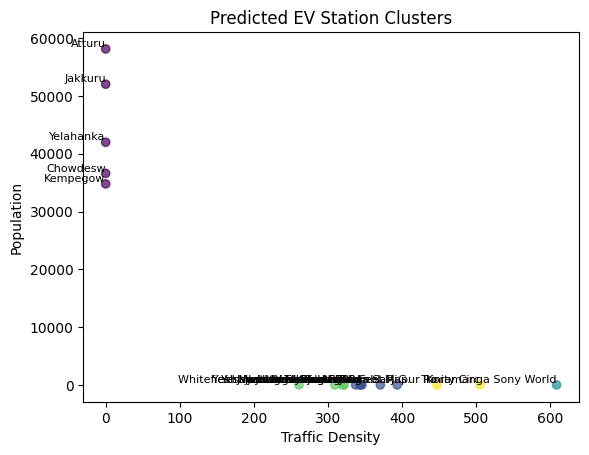

In [ ]:
def visualize_ev_stations(demand_df):
    """
    Visualizes predicted EV station clusters (replace with map-based visualization for real use).
    """
    if (len(demand_df) > 0):

        plt.figure(figsize=(6.4, 4.8))
        plt.scatter(demand_df['Traffic_Density'], demand_df['Population'], c=demand_df['Cluster'], cmap='viridis', alpha=0.7)
        plt.xlabel('Traffic Density')
        plt.ylabel('Population')
        plt.title('Predicted EV Station Clusters')

        # Annotate with Area names
        for i, row in demand_df.iterrows():
            plt.annotate(row['Area'], (row['Traffic_Density'], row['Population']), fontsize=8, ha='right', va='bottom')

        plt.show()
    else:
        print("No data to visualize")

def main():
    # Load and preprocess data
    traffic_df = load_and_clean_traffic_data()
    population_df = load_and_clean_population_data()
    ev_sales_df = load_ev_sales_data()
    ev_stations_df = load_ev_stations_data()

    # Feature Engineering
    traffic_df = calculate_traffic_density(traffic_df)
    demand_df = aggregate_data_by_area(traffic_df, population_df)
    demand_df = estimate_ev_demand(demand_df)

    # Predict EV Stations
    demand_df = predict_ev_stations(demand_df, n_clusters=5)  # You can adjust the number of clusters

    # Output and Visualization
    print(demand_df)
    visualize_ev_stations(demand_df)

if __name__ == "__main__":
    main()

<ipython-input-3-e5ce37b60c80>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  traffic_df['Road Capa'].replace(0, traffic_df['Road Capa'].max(), inplace=True)  # Avoid division by zero


                      Area  Traffic_Density  Population  Demand_Score  \
0                   Atturu         0.000000     58129.0      5.812900   
1                 Chowdesw         0.000000     36602.0      3.660200   
2       Hebbal Ballari Roa       343.275000         0.0    343.275000   
3        Hebbal Hebbal Fly       321.943192         0.0    321.943192   
4   Indiranaga 100 Feet Ri       393.521515         0.0    393.521515   
5           Indiranaga CMH       343.510000         0.0    343.510000   
6                  Jakkuru         0.000000     52025.0      5.202500   
7     Jayanagar Jayanagar.       337.365850         0.0    337.365850   
8      Jayanagar South End       345.952994         0.0    345.952994   
9                 Kempegow         0.000000     34783.0      3.478300   
10   Koramanga Sarjapur Ro       447.426974         0.0    447.426974   
11    Koramanga Sony World       608.740000         0.0    608.740000   
12       M.G.   Anil Kumbl       370.790000        

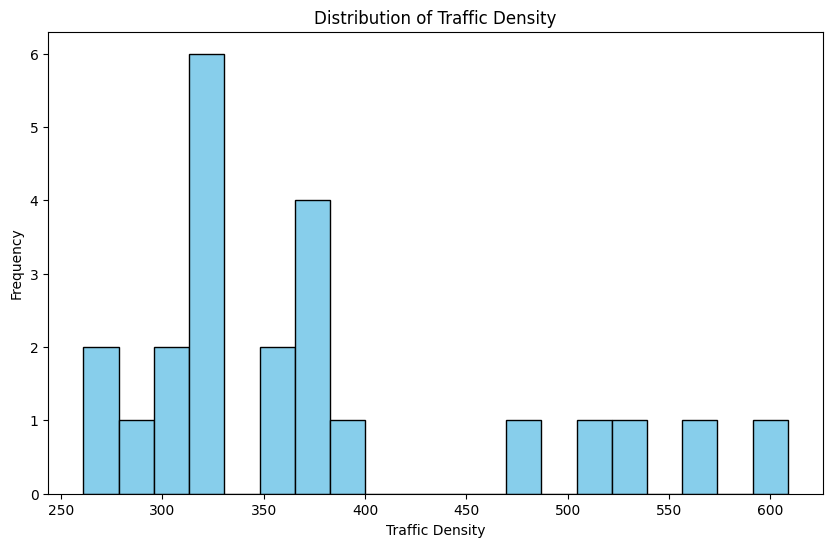

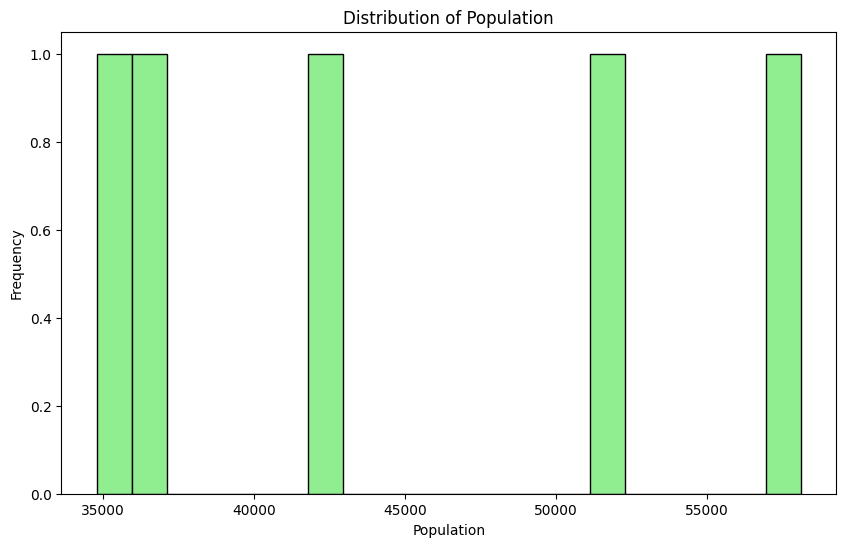

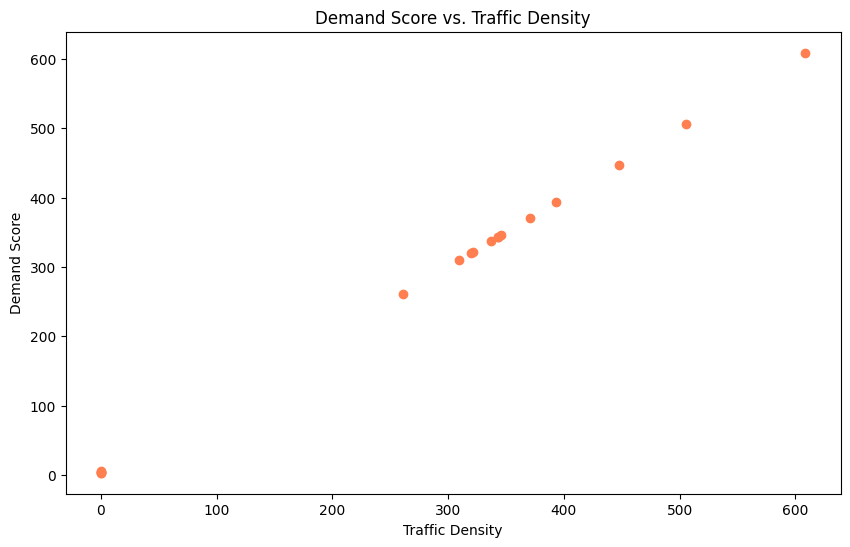

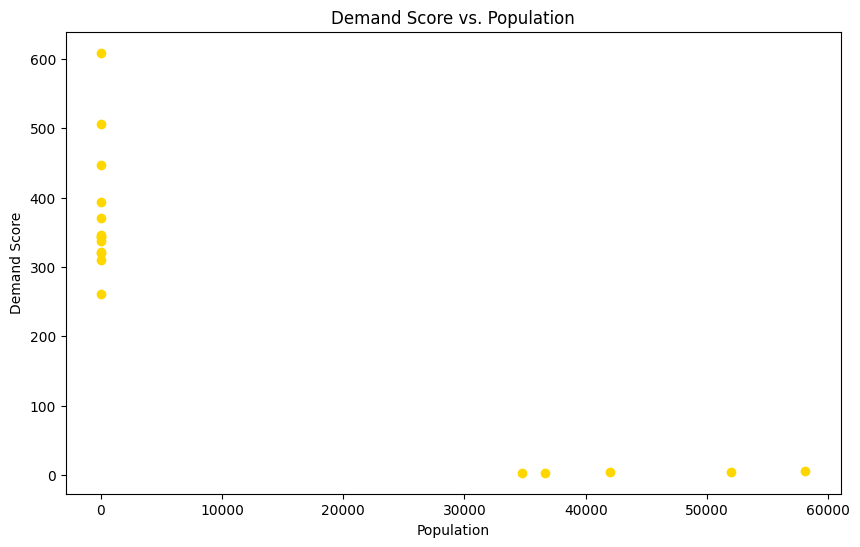

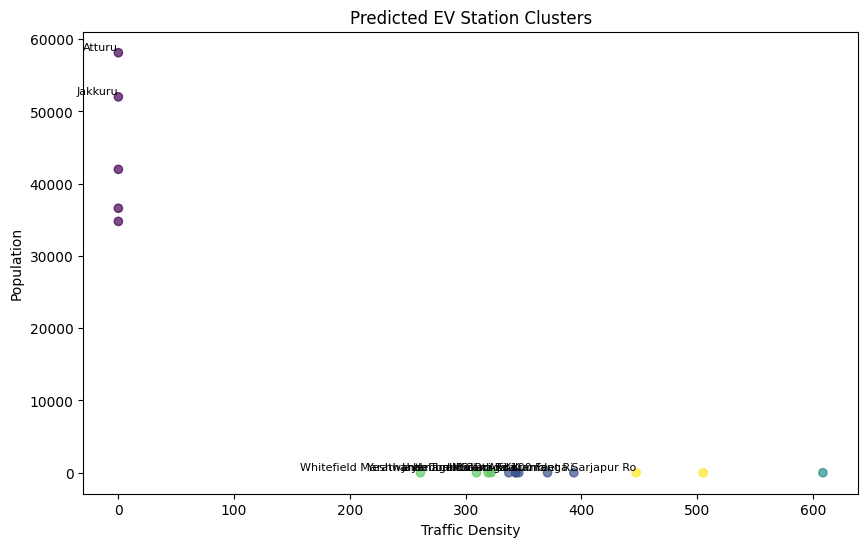

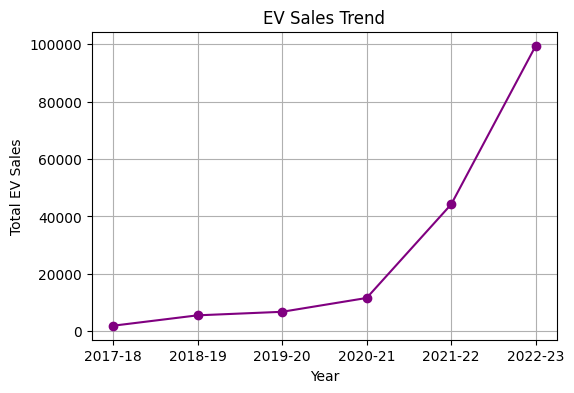

In [ ]:
def visualize_data(demand_df, traffic_df, population_df, ev_sales_df):
    """
    Visualizes the processed data using various charts.
    """

    # 1. Traffic Density Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(traffic_df['Traffic_Density'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Traffic Density')
    plt.xlabel('Traffic Density')
    plt.ylabel('Frequency')
    plt.show()

    # 2. Population Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(population_df['Population'], bins=20, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Population')
    plt.xlabel('Population')
    plt.ylabel('Frequency')
    plt.show()

    # 3. Demand Score vs. Traffic Density
    if (len(demand_df) > 0):
        plt.figure(figsize=(10, 6))
        plt.scatter(demand_df['Traffic_Density'], demand_df['Demand_Score'], color='coral')
        plt.title('Demand Score vs. Traffic Density')
        plt.xlabel('Traffic Density')
        plt.ylabel('Demand Score')
        plt.show()

        # 4. Demand Score vs. Population
        plt.figure(figsize=(10, 6))
        plt.scatter(demand_df['Population'], demand_df['Demand_Score'], color='gold')
        plt.title('Demand Score vs. Population')
        plt.xlabel('Population')
        plt.ylabel('Demand Score')
        plt.show()

        # 5. EV Station Clusters
        plt.figure(figsize=(10, 6))
        plt.scatter(demand_df['Traffic_Density'], demand_df['Population'], c=demand_df['Cluster'], cmap='viridis', alpha=0.7)
        plt.xlabel('Traffic Density')
        plt.ylabel('Population')
        plt.title('Predicted EV Station Clusters')

        # Annotate with Area names (Reduce annotations for clarity)
        for i, row in demand_df.iterrows():
            if i % 2 == 0:  # Annotate every other point
                plt.annotate(row['Area'], (row['Traffic_Density'], row['Population']), fontsize=8, ha='right', va='bottom')

        plt.show()
    else:
        print("Not enough data for Demand Score visualizations.")

    # 6. EV Sales Trend (if ev_sales_df is available)
    if ev_sales_df is not None and not ev_sales_df.empty:
        plt.figure(figsize=(6, 4))
        plt.plot(ev_sales_df['Year'], ev_sales_df['Total'], marker='o', color='purple')
        plt.title('EV Sales Trend')
        plt.xlabel('Year')
        plt.ylabel('Total EV Sales')
        plt.grid(True)
        plt.show()

def main():
    # Load and preprocess data
    traffic_df = load_and_clean_traffic_data()
    population_df = load_and_clean_population_data()
    ev_sales_df = load_ev_sales_data()
    ev_stations_df = load_ev_stations_data()

    # Feature Engineering
    traffic_df = calculate_traffic_density(traffic_df)
    demand_df = aggregate_data_by_area(traffic_df, population_df)
    demand_df = estimate_ev_demand(demand_df)

    # Predict EV Stations
    demand_df = predict_ev_stations(demand_df, n_clusters=5)  # You can adjust the number of clusters

    # Output and Visualization
    print(demand_df)
    visualize_data(demand_df, traffic_df, population_df, ev_sales_df)

if __name__ == "__main__":
    main()